In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Loading the datasets
#HPI = pd.read_csv("USSTHPI.csv") # Quarterly HPI data
HPI_PO = pd.read_csv("HPI_Purchase_only_yoy_change.csv") # HPI Purchase Only data
EHS = pd.read_excel("Existing Home Sales.xlsx") # Existing Home Sales data, Chris supplied
StockQt = pd.read_excel("HousingStockWorksheet.xlsx", sheet_name = "Stock_Quarterly") # Housing Stock data, Chris supplied

In [4]:
# Just chaging the column name and cleaning the data
HPI_PO.DATE = pd.to_datetime(HPI_PO.DATE)
new_name = {'HPIPONM226S_PC1' : "YoY"}
HPI_PO.rename(columns=new_name, inplace= True)
HPI_PO.drop(HPI_PO.tail(1).index, inplace= True)
HPI_PO.YoY = HPI_PO.YoY.astype(float)

In [5]:
StockQt.rename(columns={"Unnamed: 15" : "col 15", "Unnamed: 16" : "Eff_HS_US"}, inplace=True)
StockQt.drop(columns=["col 15"], inplace= True)
StockQt.dropna(subset=["Eff_HS_US"],inplace = True)
Quarters = StockQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
StockQt.Quarter = Dates


In [6]:
EHS.EOM = pd.to_datetime(EHS.EOM)
EHS.rename(columns= {"EOM" : "DATE"}, inplace = True)
EHS.dropna(subset=["Existing Home Sales"], inplace=True)

In [7]:
EHS["DATE"] = EHS.DATE.dt.to_period('Q')
EHS_Q = pd.DataFrame(EHS.groupby("DATE").sum())
EHS_Q.reset_index(inplace= True)
EHS_Q.drop(EHS_Q.tail(1).index,inplace=True)

In [8]:
EHS_Q["House_Stock"] = StockQt.Eff_HS_US.values

In [9]:
EHS_Q["Implied_Turnover"] = (EHS_Q["Existing Home Sales"]/(EHS_Q.House_Stock/1000))*100

In [10]:
Turnover = list(EHS_Q.Implied_Turnover.values)
Turnover = [np.nan]*(HPI_PO.shape[0]-len(Turnover))+Turnover
HPI_PO["Implied_Turnover"] = Turnover


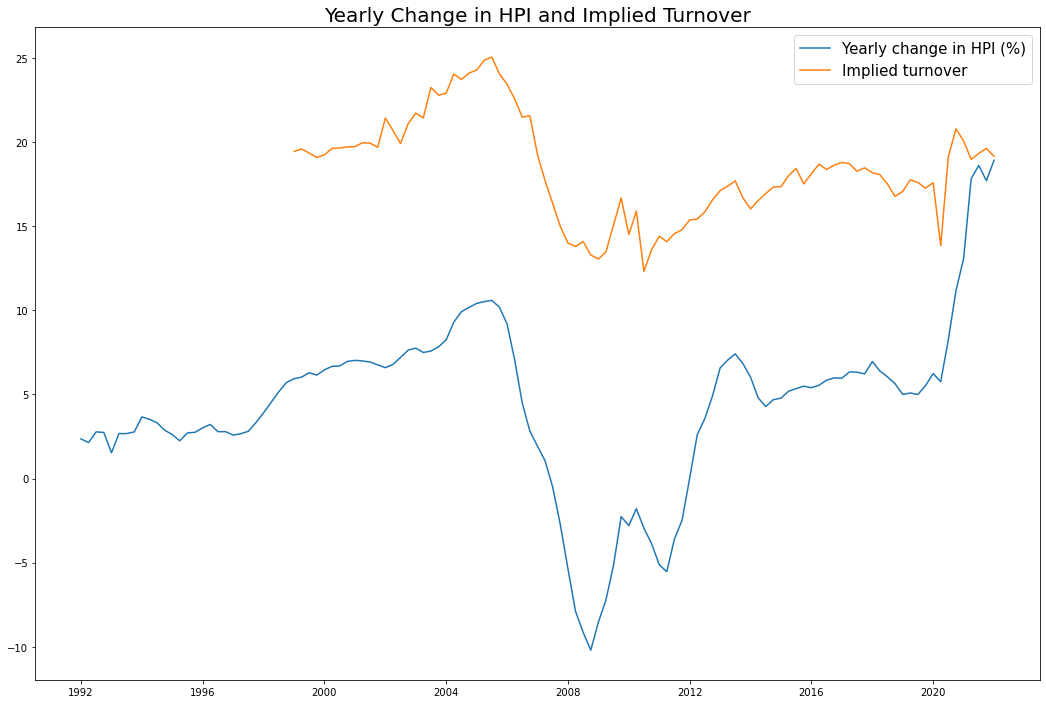

In [11]:
plt.figure(figsize=(18,12))
plt.plot(HPI_PO.DATE, HPI_PO.YoY.values, label = "Yearly change in HPI (%)")
plt.plot(HPI_PO.DATE, HPI_PO.Implied_Turnover.values, label = "Implied turnover")
plt.legend(fontsize = 15)
plt.title("Yearly Change in HPI and Implied Turnover", size = 20);

In [12]:
HPI_PO.tail(10)

,DATE,YoY,Implied_Turnover
111,2019-10-01,5.52464,17.251232
112,2020-01-01,6.23889,17.581852
113,2020-04-01,5.76118,13.840938
114,2020-07-01,8.25959,19.132467
115,2020-10-01,11.17118,20.777814
116,2021-01-01,13.08681,20.053590
117,2021-04-01,17.81826,18.965755
118,2021-07-01,18.60512,19.322235
119,2021-10-01,17.70045,19.617351
120,2022-01-01,18.91433,19.146268


In [13]:
HPI_df = HPI_PO.dropna().reset_index(drop=True)

In [14]:
size=int(HPI_df.shape[0]*0.8)

In [15]:
train, test = HPI_df.iloc[:size,:], HPI_df.iloc[size:,:]

In [16]:
X_train, y_train = train['YoY'], train['Implied_Turnover']
X_test, y_test = test['YoY'], test['Implied_Turnover']

In [17]:
X_train=np.array(X_train).reshape(-1, 1)
X_test= np.array(X_test).reshape(-1, 1)
np.array(y_train).reshape(-1,1)
np.array(y_test).reshape(-1,1)

array([[18.26289607],
       [18.46532622],
       [18.17296412],
       [18.06130903],
       [17.50597671],
       [16.7680762 ],
       [17.065559  ],
       [17.74576122],
       [17.60024321],
       [17.25123185],
       [17.5818521 ],
       [13.84093807],
       [19.13246677],
       [20.77781435],
       [20.05358966],
       [18.96575539],
       [19.32223543],
       [19.61735097],
       [19.14626822]])

In [18]:
y_test

74    18.262896
75    18.465326
76    18.172964
77    18.061309
78    17.505977
79    16.768076
80    17.065559
81    17.745761
82    17.600243
83    17.251232
84    17.581852
85    13.840938
86    19.132467
87    20.777814
88    20.053590
89    18.965755
90    19.322235
91    19.617351
92    19.146268
Name: Implied_Turnover, dtype: float64

In [19]:
from sklearn.linear_model import LinearRegression

# Fit and predict
model = LinearRegression()  
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
y_fore = model.predict(X_test)

In [20]:
y_fore

array([19.84475148, 19.79055634, 20.17207   , 19.88241884, 19.70103865,
       19.48765079, 19.15684619, 19.20314576, 19.15579829, 19.429622  ,
       19.80014826, 19.55233013, 20.84841207, 22.35883638, 23.35259379,
       25.8070936 , 26.21528723, 25.74597817, 26.37569384])

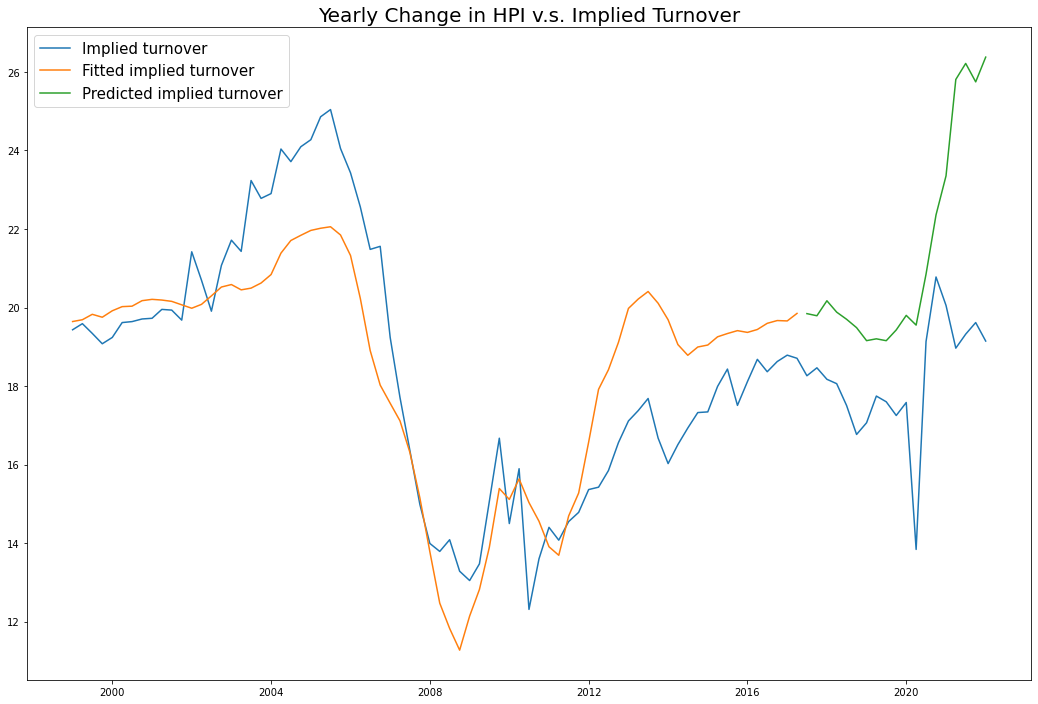

In [21]:
plt.figure(figsize=(18,12))
plt.plot(HPI_df.DATE, HPI_df.Implied_Turnover.values, label = "Implied turnover")
plt.plot(train.DATE, y_pred, label = "Fitted implied turnover")
plt.plot(test.DATE, y_fore, label = "Predicted implied turnover")
plt.legend(fontsize = 15)
plt.title("Yearly Change in HPI v.s. Implied Turnover", size = 20);

In [22]:
HPI_df

,DATE,YoY,Implied_Turnover
0,1999-01-01,5.93694,19.433808
1,1999-04-01,6.02527,19.589250
2,1999-07-01,6.29097,19.341401
3,1999-10-01,6.14804,19.077584
4,2000-01-01,6.46462,19.238388
...,...,...,...
88,2021-01-01,13.08681,20.053590
89,2021-04-01,17.81826,18.965755
90,2021-07-01,18.60512,19.322235
91,2021-10-01,17.70045,19.617351


In [23]:
# Make lag features for 'CPR_1M'
def make_lags(ts, lags):
    return pd.concat(
        {
            f'Implied_Turnnover_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(HPI_df['Implied_Turnover'], lags=1)

In [24]:
X.fillna(0)

,Implied_Turnnover_lag_1
0,0.000000
1,19.433808
2,19.589250
3,19.341401
4,19.077584
...,...
88,20.777814
89,20.053590
90,18.965755
91,19.322235


In [25]:
HPI_lag2=pd.concat([HPI_df, X], axis=1)

In [26]:
HPI_lag2.fillna(0,inplace=True)

In [27]:
HPI_lag2.columns

Index(['DATE', 'YoY', 'Implied_Turnover', 'Implied_Turnnover_lag_1'], dtype='object')

In [28]:
features = ['YoY', 'Implied_Turnnover_lag_1']

In [29]:
train1, test1 = HPI_lag2.iloc[:size,:], HPI_lag2.iloc[size:,:]

In [30]:
train1

,DATE,YoY,Implied_Turnover,Implied_Turnnover_lag_1
0,1999-01-01,5.93694,19.433808,0.000000
1,1999-04-01,6.02527,19.589250,19.433808
2,1999-07-01,6.29097,19.341401,19.589250
3,1999-10-01,6.14804,19.077584,19.341401
4,2000-01-01,6.46462,19.238388,19.077584
...,...,...,...,...
69,2016-04-01,5.54618,18.680930,18.114837
70,2016-07-01,5.84897,18.365431,18.680930
71,2016-10-01,5.98514,18.624754,18.365431
72,2017-01-01,5.96637,18.787409,18.624754


In [31]:
X1_train, y1_train = train1[features], train1['Implied_Turnover']
X1_test, y1_test = test1[features], test1['Implied_Turnover']

In [32]:
y1_train

0     19.433808
1     19.589250
2     19.341401
3     19.077584
4     19.238388
        ...    
69    18.680930
70    18.365431
71    18.624754
72    18.787409
73    18.707559
Name: Implied_Turnover, Length: 74, dtype: float64

In [33]:
# Fit and predict
model1 = LinearRegression()  
model1.fit(X1_train, y1_train)
y1_pred = model1.predict(X1_train)
y1_fore = model1.predict(X1_test)

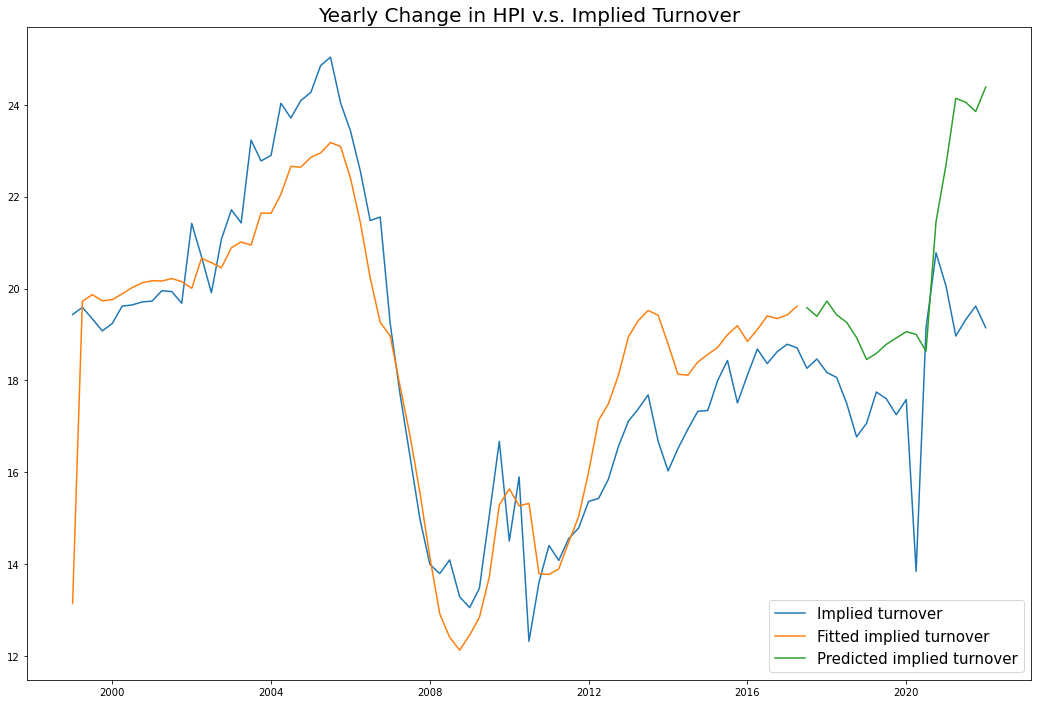

In [34]:
plt.figure(figsize=(18,12))
plt.plot(HPI_df.DATE, HPI_df.Implied_Turnover.values, label = "Implied turnover")
plt.plot(train1.DATE, y1_pred, label = "Fitted implied turnover")
plt.plot(test1.DATE, y1_fore, label = "Predicted implied turnover")
plt.legend(fontsize = 15)
plt.title("Yearly Change in HPI v.s. Implied Turnover", size = 20);